# Optimization of E. coli growth parameters for NUFEB
This notebook utilizes hyperparameter optimization to fit simulated E. coli growth curves to experimental data. Under the hood, we use scikit-optimize to perform a Bayesian optimization.

In [1]:
#Imports
import os
from random import uniform
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel
import joblib
import subprocess
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize,load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective,plot_gaussian_process
from scipy.optimize import curve_fit
from scipy import interpolate
from skopt import Optimizer
from skopt.space import Real
from skopt.benchmarks import branin
from distributed import Client,progress, as_completed,wait,get_client
import shutil
from dask import dataframe as dd
from dask import delayed


In [2]:
client = Client(threads_per_worker=1)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 25.02 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41113,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 25.02 GiB
Comm: tcp://127.0.0.1:34551,Total threads: 1
Dashboard: http://127.0.0.1:37791/status,Memory: 1.56 GiB
Nanny: tcp://127.0.0.1:45937,


In [4]:
help(client)

Help on Client in module distributed.client object:

class Client(distributed.utils.SyncMethodMixin)
 |  Client(address=None, loop=None, timeout='__no_default__', set_as_default=True, scheduler_file=None, security=None, asynchronous=False, name=None, heartbeat_interval=None, serializers=None, deserializers=None, extensions=[<class 'distributed.pubsub.PubSubClientExtension'>], direct_to_workers=None, connection_limit=512, **kwargs)
 |  
 |  Connect to and submit computation to a Dask cluster
 |  
 |  The Client connects users to a Dask cluster.  It provides an asynchronous
 |  user interface around functions and futures.  This class resembles
 |  executors in ``concurrent.futures`` but also allows ``Future`` objects
 |  within ``submit/map`` calls.  When a Client is instantiated it takes over
 |  all ``dask.compute`` and ``dask.persist`` calls by default.
 |  
 |  It is also common to create a Client without specifying the scheduler
 |  address , like ``Client()``.  In this case the Cli

In [5]:
from tqdm.notebook import tqdm
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()

    def __getstate__(self):
        state = self.__dict__.copy()
        del state['_bar']
        return state

In [6]:
expPath = r'/home/jsakkos/nufeb-cyano-e-coli/experimental-data/ecw-growth-R2.xlsx'
growthData = pd.read_excel(expPath,sheet_name='Growth')
expSucrose =pd.read_excel(expPath,sheet_name='Sucrose')

In [7]:
growthData = growthData.loc[growthData['Initial Sucrose'] !=20]
growthData=growthData.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','OD600']]
growthData.head()

,Time,Initial Sucrose,OD600
0,0,2,0.010000
1,0,5,0.010000
2,0,10,0.010000
3,1,2,0.010000
4,1,5,0.016333


In [8]:
expSucrose = expSucrose.loc[expSucrose['Initial Sucrose'] !=20]
expSucrose = expSucrose.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','Sucrose']]
expSucrose.head()

,Time,Initial Sucrose,Sucrose
0,0,2,1.855295
1,0,5,4.685920
2,0,10,9.489184
3,4,2,1.808598
4,4,5,4.631757


# Optimization function
## Parameters to optimize:
### $\mu_{max}$ (Monod-based growth rate, $s^{-1}$)
### $\rho$ (Cell density, $\frac{kg}{m^3}$)
### $k_{sucrose}$ (Sucrose uptake half-maximum, $\frac{kg}{m^3}$)
### m (Cellular maintenance cost, $s^{-1}$)

In [9]:
#Volume = 1e-4*1e-4*1e-4 #m^3
#mlm3 = 1e6 #mL/m^3
#Biomass2OD = Volume*.44


In [10]:
def mu_func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))

In [11]:
def run_sim(folder):
    os.chdir(folder)
    in_path = folder / 'Inputscript.lammps'
    try:
        os.system(f'mpirun -np 1 /home/jsakkos/NUFEB/lammps/src/lmp_png -in {in_path} > nufeb.log')
        #subprocess.run(['mpirun', '-np', '4','/home/jsakkos/NUFEB/lammps/src/lmp_png','-in', '*.lammps > nufeb.log'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        #os.chdir(r'/home/jsakkos/NUFEB')
        return folder
    except:
        print('Something went wrong')
def collect_data(folder):
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp
def run_collect(folder):
    os.chdir(folder)
    in_path = folder / 'Inputscript.lammps'
    os.system(f'mpirun -np 1 /home/jsakkos/NUFEB/lammps/src/lmp_png -in {in_path} > nufeb.log')
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp
def test(x,growth=growthData,sucrose=expSucrose):
   
    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    maint = 0#x[3]
    SucroseMW = 342.3
    client = get_client()
    os.chdir('/home/jsakkos/NUFEB')
    SucroseMW = 342.3
    rng = str(np.random.randint(0,1e6,1)[0])
    os.mkdir(rng)
    os.chdir(rng)
    dir_path = Path(os.getcwd()).resolve()
    for s in growthData['Initial Sucrose'].unique():
        suc = s*1e3/SucroseMW
        text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint} --niter 1000 --mass 7e-12'
        os.system(text)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
    futures =client.map(run_collect,folders)
    wait(futures,return_when='ALL_COMPLETED')
    data=pd.concat((futures[i].result() for i in range(3)),ignore_index=True) 
    df = data.groupby(['Hours','S0']).mean().reset_index()
    rmse = 0
    r2g=0
    r2s=0
    for s in growthData['Initial Sucrose'].unique():
        temp = growthData.loc[growthData['Initial Sucrose']==s]
        g=interpolate.interp1d(df.Hours,df.OD600)
        rmse += mean_squared_error(temp.OD600, g(temp.Time), sample_weight=temp.OD600,squared = False)
        r2g += r2_score(temp.OD600, g(temp.Time))
        temp2 = expSucrose.loc[expSucrose['Initial Sucrose']==s]
        suc=interpolate.interp1d(df.Hours,df.Sucrose)
        #rmse += mean_squared_error(temp2.Sucrose, suc(temp2.Time), sample_weight=temp2.Sucrose,squared = False)
        r2s += r2_score(temp2.Sucrose, suc(temp2.Time))
    r2g=r2g/len(growthData['Initial Sucrose'].unique())
    r2s=r2s/len(growthData['Initial Sucrose'].unique())
    os.chdir('/home/jsakkos/NUFEB')
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    return rmse


In [12]:
def check_result(x,growth=growthData,sucrose=expSucrose):
    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    maint = 0#x[3]
    SucroseMW = 342.3
    client = get_client()
    os.chdir('/home/jsakkos/NUFEB')
    SucroseMW = 342.3
    rng = str(np.random.randint(0,1e6,1)[0])
    os.mkdir(rng)
    os.chdir(rng)
    dir_path = Path(os.getcwd()).resolve()
    for s in growthData['Initial Sucrose'].unique():
        suc = s*1e3/SucroseMW
        text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint} --niter 1000 --mass 7e-12'
        os.system(text)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
    futures =client.map(run_collect,folders)
    wait(futures,return_when='ALL_COMPLETED')
    data=pd.concat((futures[i].result() for i in range(3)),ignore_index=True) 
    df = data.groupby(['Hours','S0']).mean().reset_index()
    f, axes = plt.subplots(ncols=2)
    sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
    sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
    sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
    sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])
    #plot
    sns.despine()
    plt.show()
    rmse = 0
    r2g=0
    r2s=0
    for s in growthData['Initial Sucrose'].unique():
        temp = growthData.loc[growthData['Initial Sucrose']==s]
        g=interpolate.interp1d(df.Hours,df.OD600)
        rmse += mean_squared_error(temp.OD600, g(temp.Time), sample_weight=temp.OD600,squared = False)
        r2g += r2_score(temp.OD600, g(temp.Time))
        temp2 = expSucrose.loc[expSucrose['Initial Sucrose']==s]
        suc=interpolate.interp1d(df.Hours,df.Sucrose)
        #rmse += mean_squared_error(temp2.Sucrose, suc(temp2.Time), sample_weight=temp2.Sucrose,squared = False)
        r2s += r2_score(temp2.Sucrose, suc(temp2.Time))
    r2g=r2g/len(growthData['Initial Sucrose'].unique())
    r2s=r2s/len(growthData['Initial Sucrose'].unique())

    print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')
    os.chdir('/home/jsakkos/NUFEB')
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    return rmse


In [13]:
optimizer = Optimizer(
    dimensions=[Real(float('1e-4'), float('8e-4')), 
                Real(150, 307),
                Real(float('1e-1'),float('1.5e1'))],
    random_state=1,
    base_estimator='gp'
)

futures = []
for x in optimizer.ask(n_points=10):
    x = [round(elem,8) for elem in x] 
    futures.append(client.submit(lambda x: (x, test(x)), x))
seq = as_completed(futures) # iterate over futures in completion order
for future in seq:
    x, y = future.result()
    optimizer.tell(x, y)
    if len(optimizer.Xi) > 50: # exit condition
        continue
    next_x = optimizer.ask()
    next_x = [round(elem,8) for elem in next_x] 
    seq.add(client.submit(lambda x: (x, test(x)), next_x))

print(min(optimizer.yi)) # print the best objective found

11.529993867533776


In [14]:
optimizer.get_result()

          fun: 11.529993867533776
    func_vals: array([19.39190091, 13.40099323, 11.78021071, 17.63016255, 12.53073143,
       12.19049217, 18.83790313, 15.97833062, 12.2837141 , 17.78521074,
       18.51696364, 15.09069018, 18.48014207, 13.82095321, 12.16274632,
       16.28726641, 11.57928027, 12.85004478, 11.52999387, 12.33431311,
       12.38483014, 14.10704128, 12.6712019 , 12.19961294, 12.09091718,
       12.19321391, 12.7339405 , 12.19580375, 12.04049715, 12.04049715,
       12.11892312, 12.82321028, 12.82321028, 12.82321028, 12.82321028,
       12.82321028, 12.82321028, 12.13838491, 12.60352665, 12.68772346,
       12.48280284, 12.52343233, 12.0541548 , 11.99444413, 12.22030076,
       11.85497735, 12.48439205, 12.50757779, 11.66556459, 12.44155466,
       12.09944995, 11.77067887, 12.05481022, 12.05203832, 11.81386235,
       11.7176767 , 12.1672682 , 11.73963049, 11.73871124, 11.67241185])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], 

In [15]:
optimizer.get_result().x

[0.00039211, 237.71430307, 2.19176539]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

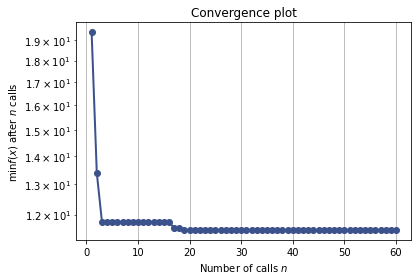

In [16]:
plot_convergence(optimizer.get_result(),yscale='log')

array([[<AxesSubplot:xlabel='$\\mu$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$\\rho$'>,
        <AxesSubplot:xlabel='$\\rho$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$\\mu$', ylabel='$K_{sucrose}$'>,
        <AxesSubplot:xlabel='$\\rho$'>,
        <AxesSubplot:xlabel='$K_{sucrose}$', ylabel='Partial dependence'>]],
      dtype=object)

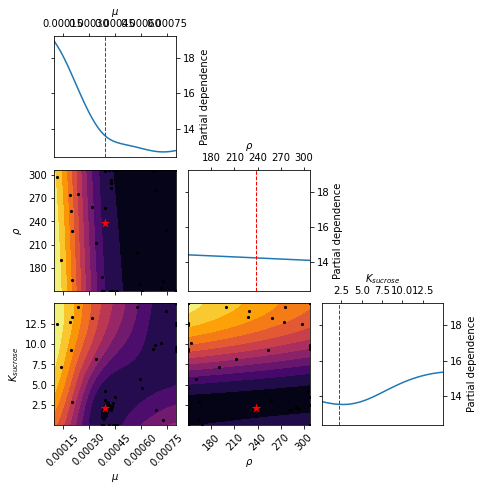

In [17]:
plot_objective(optimizer.get_result(),dimensions=[r'$\mu$',r'$\rho$',r'$K_{sucrose}$'],cmap='inferno')

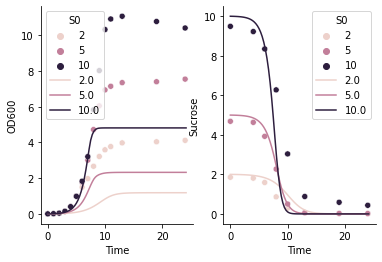

R2 = 0.295 (growth),-6.483 (sucrose)


11.727595653688779

In [18]:
check_result(optimizer.get_result().x)